이번 과제에서는 손으로 그린 스케치 정보를 가져와 수행을 할 것입니다.
구글의 Quick Draw 데이터셋을 이용하여 진행해볼 것인데, 손 낙서 데이터는 벡터 포맷으로 저장되어 있어서 비트맵 형태로 변환하여 사용해야 합니다.

이번 오토인코더에서는 '고양이 스러움'을 학습하는 모델을 구현합니다. 고양이라는 낙서의 내적 표상(internal represent)을 latent가 갖도록 하는 것입니다. 

- 구글의 Quick Draw는 사용자가 그린 낙서를 AI가 맞추는 온라인 게임이며,
- 데이터는 다양한 포맷으로 제공되는데,
- 이번 샘플에서는 Binary encoding된 낙서 데이터를 이용할 것입니다..


사용할 라이브러리들을 불러옵니다.

In [21]:
# import matplotlib.pyplot as plt
# import json, glob
import numpy as np
import tensorflow as tf
from tensorflow import keras

고양이 정보를 수집할 주소를 입력합니다.

In [2]:
from keras.utils import get_file

BASE_PATH = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
path = get_file('cat', BASE_PATH + 'cat.bin')

19571324/19571324 [==============================] - 2s 0us/step


In [7]:
import PIL
from PIL import ImageDraw
from struct import unpack
from sklearn.model_selection import train_test_split

def load_drows(path, train_size=0.85):
    x = []
    # 파일을 풀고 낙서를 하나하나 모은다. 낙서는 15바이트 헤더로 시작한다.
    with open(path, 'rb') as f:
        while True:
            img = PIL.Image.new('L', (32, 32), 'white') # 8-bit pixels, black and white #https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
            draw = ImageDraw.Draw(img)
            header = f.read(15)
            if len(header) != 15:
                break
            # 낙서는 x,y 좌표로 구성된 획(stroke) 목록으로 되어 있고, 각 좌표는 분리되어 저장되어 있다.
            # 방금 위에서 생성한 ImageDraw 객체의 좌표 목록을 이용하기 위해 zip()함수를 사용하여 합쳐준다.
            strokes, = unpack('H', f.read(2))
            for i in range(strokes):
                n_points, = unpack('H', f.read(2))
                fmt = str(n_points) + 'B'
                read_scaled = lambda: (p // 8 for 
                                       p in unpack(fmt, f.read(n_points)))
                points = [*zip(read_scaled(), read_scaled())]               # zip 함수
                draw.line(points, fill=0, width=2)
            img = tf.keras.utils.img_to_array(img)
            x.append(img)
    x = np.asarray(x) / 255
    return train_test_split(x, train_size=train_size)

# 입력받은 10만개의 고양이 낙서 데이터를 활용할 수 있다. 
x_train, x_test = load_drows(path)
print(x_train.shape, x_test.shape) # ((104721, 32, 32, 1), (18481, 32, 32, 1))

(104721, 32, 32, 1) (18481, 32, 32, 1)


In [15]:


from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.losses import binary_crossentropy, kullback_leibler_divergence
from tensorflow.keras import backend as K

def create_AE():
    input_img = Input(shape=(32, 32, 1))

    channels = 2
    x = input_img
    for i in range(4):
        channels *= 2
        # 여기에 다운샘플링 할 수 있는 코드를 제작하세요.
        # 구조는 아래 첨부된 이미지를 참조하세요.
        # 사용할 함수 : Conv2D(activation='relu', padding='same'), Concatenate(), MaxPooling2D(padding='same')

        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)

    x = Dense(32)(x)

    for i in range(4):
        # 여기에 업샘플링할 수 있는 코드를 제작 하세요. 
        # 사용할 함수 : Conv2D(activation='relu', padding='same'), UpSampling2D(padding='same')

        x = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        channels /= 2

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return autoencoder

autoencoder = create_AE()
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 4)    40          ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 4)    20          ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 8)    0           ['conv2d_1[0][0]',               
                                                                  'conv2d_2[0][0]']         

In [16]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100
819/819 [==============================] - 26s 11ms/step - loss: 0.6878 - val_loss: 0.6860
Epoch 2/100
819/819 [==============================] - 7s 9ms/step - loss: 0.6827 - val_loss: 0.6779
Epoch 3/100
819/819 [==============================] - 8s 10ms/step - loss: 0.6659 - val_loss: 0.6459
Epoch 4/100
819/819 [==============================] - 8s 9ms/step - loss: 0.6217 - val_loss: 0.6088
Epoch 5/100
819/819 [==============================] - 7s 8ms/step - loss: 0.6026 - val_loss: 0.5965
Epoch 6/100
819/819 [==============================] - 8s 9ms/step - loss: 0.5911 - val_loss: 0.5858
Epoch 7/100
819/819 [==============================] - 7s 9ms/step - loss: 0.5817 - val_loss: 0.5776
Epoch 8/100
819/819 [==============================] - 8s 9ms/step - loss: 0.5746 - val_loss: 0.5711
Epoch 9/100
819/819 [==============================] - 8s 10ms/step - loss: 0.5688 - val_loss: 0.5659
Epoch 10/100
819/819 [==============================] - 7s 9ms/step - loss: 0.5641 - va

In [17]:
cols = 25
idx = np.random.randint(x_test.shape[0], size=cols)
sample = x_test[idx]
decoded_imgs = autoencoder.predict(sample)
decoded_imgs.shape

1/1 [==============================] - 1s 884ms/step


(25, 32, 32, 1)

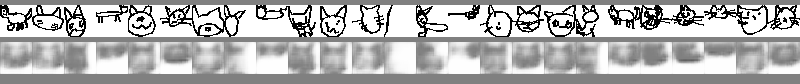

In [22]:
from keras.layers import Reshape, Concatenate, Flatten, Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from IPython.display import Image, display
from io import BytesIO

def decode_img(tile, factor=1.0):
    tile = tile.reshape(tile.shape[:-1])
    tile = np.clip(tile * 255, 0, 255)
    return PIL.Image.fromarray(tile)
    

overview = PIL.Image.new('RGB', (cols * 32, 64 + 20), (128, 128, 128))
for idx in range(cols):
    overview.paste(decode_img(sample[idx]), (idx * 32, 5))
    overview.paste(decode_img(decoded_imgs[idx]), (idx * 32, 42))
f = BytesIO()
overview.save(f, 'png')
display(Image(data=f.getvalue()))